# 基于CNN＋CTC的中文语音识别

数据：清华大学开源TSCHS30中文语料库(下载地址：http://www.openslr.org/18/)<br/>
语言：python+Tensorflow

In [1]:
import os 
source_file = 'D:\SIGS_homework\pvoice\yuyinshibie\data_thchs30'#数据路径

In [2]:
#读取data文件夹下面的数据
#train或者test文件下面的标签文件全在data里面
def source_get(source_file):
    train_file = source_file + '\data'
    label_lst = []
    wav_lst = []
    #root 所指的是当前正在遍历的这个文件夹的本身的地址
    #dirs 是一个 list ，内容是该文件夹中所有的目录的名字(不包括子目录)
    #files 同样是 list , 内容是该文件夹中所有的文件(不包括子目录)
    for root, dirs, files in os.walk(train_file):
        for file in files:
            if file.endswith('.wav'):
                wav_file = os.sep.join([root, file])
                label_file = wav_file + '.trn'
                wav_lst.append(wav_file)
                label_lst.append(label_file)
            
    return label_lst, wav_lst  #返回.wav和.trn文件路径的列表
label_lst, wav_lst = source_get(source_file)

In [3]:
#读取音频文件对应的拼音label
#总共13388对数据
def read_label(label_file):
    with open(label_file, 'r', encoding='utf8') as f: #对.trn文件的读取（.trn为日志格式）
        data = f.readlines()
        return data[0]  #返回三种标签中的汉字标签（汉字，音节，音素）

#将所有label中的汉字统一存储在一个字典中（list，总共13388个label）
def gen_label_data(label_lst):
    label_data = []
    for label_file in label_lst:
        pny = read_label(label_file)
        label_data.append(pny.strip('\n'))
    return label_data

label_data = gen_label_data(label_lst)
print(len(label_data))


13388


In [4]:
#对汉字进行数字编码
def mk_vocab(label_data):
    vocab = []
    for line in label_data:
        line = line.split(' ')
        for pny in line:
            if pny not in vocab:
                vocab.append(pny)
    vocab.append('_')
    return vocab

vocab = mk_vocab(label_data)
print("label中不同拼音的个数：",len(vocab))


#找出拼音对应的数字id
def word2id(line, vocab):
    return [vocab.index(pny) for pny in line.split(' ')]

label_id = word2id(label_data[0], vocab)


label中不同拼音的个数： 8874


(777, 200)


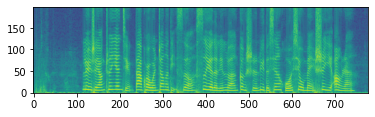

(776, 200)


In [5]:
#音频数据的处理
import numpy as np
import scipy.io.wavfile as wav
from scipy.fftpack import fft
import matplotlib.pyplot as plt
%matplotlib inline

# 获取信号的时频图
def compute_fbank(file):
    x=np.linspace(0, 400 - 1, 400, dtype = np.int64)
    w = 0.54 - 0.46 * np.cos(2 * np.pi * (x) / (400 - 1) ) # 汉明窗
    fs, wavsignal = wav.read(file)
    # wav波形 加时间窗以及时移10ms
    time_window = 25 # 单位ms
    window_length = fs / 1000 * time_window # 计算窗长度的公式，目前全部为400固定值
    wav_arr = np.array(wavsignal)
    wav_length = len(wavsignal)
    range0_end = int(len(wavsignal)/fs*1000 - time_window) // 10 # 计算循环终止的位置，也就是最终生成的窗数
    data_input = np.zeros((range0_end, 200), dtype = np.float) # 用于存放最终的频率特征数据
    data_line = np.zeros((1, 400), dtype = np.float)
    for i in range(0, range0_end):
        p_start = i * 160
        p_end = p_start + 400
        data_line = wav_arr[p_start:p_end]	
        data_line = data_line * w # 加窗
        data_line = np.abs(fft(data_line))
        data_input[i]=data_line[0:200] # 设置为400除以2的值（即200）是取一半数据，因为是对称的
    data_input = np.log(data_input + 1)
    #data_input = data_input[::]
    return data_input

fbank = compute_fbank(wav_lst[0])
print(fbank.shape)

plt.imshow(fbank.T, origin = 'lower')
plt.show()

#将长宽设置为8的整数倍
fbank = fbank[:fbank.shape[0]//8*8, :]
print(fbank.shape)


In [6]:
#数据生成（batch）
total_nums = 10000 #训练数据取13388中的10000个
batch_size = 4
batch_num = total_nums // batch_size
from random import shuffle
shuffle_list = [i for i in range(10000)]
shuffle(shuffle_list)#对生成的索引进行打乱

def get_batch(batch_size, shuffle_list, wav_lst, label_data, vocab):
    for i in range(10000//batch_size):
        wav_data_lst = []
        label_data_lst = []
        begin = i * batch_size
        end = begin + batch_size
        sub_list = shuffle_list[begin:end]
        for index in sub_list:
            fbank = compute_fbank(wav_lst[index])
            fbank = fbank[:fbank.shape[0] // 8 * 8, :]  #将语谱图的宽度调整为8的倍数
            label = word2id(label_data[index], vocab)
            wav_data_lst.append(fbank)
            label_data_lst.append(label)
        yield wav_data_lst, label_data_lst

batch = get_batch(4, shuffle_list, wav_lst, label_data, vocab)

wav_data_lst, label_data_lst = next(batch)
for wav_data in wav_data_lst:
    print(wav_data.shape)
#for label_data in label_data_lst:
 #   print(len(label_data))

(760, 200)
(816, 200)
(920, 200)
(928, 200)


In [7]:
#padding对一个batch中的音频文件进行补零
def wav_padding(wav_data_lst):
    wav_lens = [len(data) for data in wav_data_lst]
    wav_max_len = max(wav_lens)  #找一个batch中语谱图最长的
    wav_lens = np.array([leng//8 for leng in wav_lens])
    new_wav_data_lst = np.zeros((len(wav_data_lst), wav_max_len, 200, 1))#高统一为200
    for i in range(len(wav_data_lst)):
        new_wav_data_lst[i, :wav_data_lst[i].shape[0], :, 0] = wav_data_lst[i]
    return new_wav_data_lst, wav_lens

pad_wav_data_lst, wav_lens = wav_padding(wav_data_lst)
print("标准化后batch的数据格式：",pad_wav_data_lst.shape)
print("每个label的长度：",wav_lens)

标准化后batch的数据格式： (4, 928, 200, 1)
每个label的长度： [ 95 102 115 116]


In [8]:
#label的padding，不过label的长度不需要补充
#label的长度就是输入给ctc的长
def label_padding(label_data_lst):
    label_lens = np.array([len(label) for label in label_data_lst])
    max_label_len = max(label_lens)
    new_label_data_lst = np.zeros((len(label_data_lst), max_label_len))
    for i in range(len(label_data_lst)):
        new_label_data_lst[i][:len(label_data_lst[i])] = label_data_lst[i]
    return new_label_data_lst, label_lens

pad_label_data_lst, label_lens = label_padding(label_data_lst)
print(pad_label_data_lst.shape)
print(label_lens)

(4, 20)
[17 20 20 16]


训练数据格式的最终生成

In [9]:
def data_generator(batch_size, shuffle_list, wav_lst, label_data, vocab):
    for i in range(len(wav_lst)//batch_size):
        wav_data_lst = []
        label_data_lst = []
        begin = i * batch_size
        end = begin + batch_size
        sub_list = shuffle_list[begin:end]
        for index in sub_list:
            fbank = compute_fbank(wav_lst[index])
            pad_fbank = np.zeros((fbank.shape[0]//8*8+8, fbank.shape[1]))
            pad_fbank[:fbank.shape[0], :] = fbank
            label = word2id(label_data[index], vocab)
            wav_data_lst.append(pad_fbank)
            label_data_lst.append(label)
        pad_wav_data, input_length = wav_padding(wav_data_lst)
        pad_label_data, label_length = label_padding(label_data_lst)
        inputs = {'the_inputs': pad_wav_data,
                  'the_labels': pad_label_data,
                  'input_length': input_length,
                  'label_length': label_length,
                 }
        outputs = {'ctc': np.zeros(pad_wav_data.shape[0],)} 
        yield inputs, outputs  #与return的不同之处就是可以配合next函数迭代读取数据

模型搭建

In [10]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
import keras
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D
from keras.layers import Reshape, Dense, Lambda
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from keras.utils import multi_gpu_model



Using TensorFlow backend.


In [11]:
#模型组件
def conv2d(size):
    return Conv2D(size, (3,3), use_bias=True, activation='relu',
        padding='same', kernel_initializer='he_normal')
def norm(x):
    return BatchNormalization(axis=-1)(x)
def maxpool(x):
    return MaxPooling2D(pool_size=(2,2), strides=None, padding="valid")(x)
def dense(units, activation="relu"):
    return Dense(units, activation=activation, use_bias=True,
        kernel_initializer='he_normal')  #对卷积核的值进行初始化
def cnn_cell(size, x, pool=True):
    x = norm(conv2d(size)(x))
    x = norm(conv2d(size)(x))
    if pool:
        x = maxpool(x)
    return x
def ctc_lambda(args):
    labels, y_pred, input_length, label_length = args
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [14]:
class Amodel():
    """docstring for Amodel."""
    def __init__(self, vocab_size):
        super(Amodel, self).__init__()
        self.vocab_size = vocab_size
        self._model_init()
        self._ctc_init()
        self.opt_init()

    def _model_init(self):
        self.inputs = Input(name='the_inputs', shape=(None, 200, 1))
        self.h1 = cnn_cell(32, self.inputs)
        self.h2 = cnn_cell(64, self.h1)
        self.h3 = cnn_cell(128, self.h2)
        self.h4 = cnn_cell(128, self.h3, pool=False)
        # 200 / 8 * 128 = 3200
        self.h6 = Reshape((-1, 3200))(self.h4)
        self.h7 = dense(256)(self.h6)
        self.outputs = dense(self.vocab_size, activation='softmax')(self.h7)
        self.model = Model(inputs=self.inputs, outputs=self.outputs)

    def _ctc_init(self):
        self.labels = Input(name='the_labels', shape=[None], dtype='float32')
        self.input_length = Input(name='input_length', shape=[1], dtype='int64')
        self.label_length = Input(name='label_length', shape=[1], dtype='int64')
        self.loss_out = Lambda(ctc_lambda, output_shape=(1,), name='ctc')\
            ([self.labels, self.outputs, self.input_length, self.label_length])
        self.ctc_model = Model(inputs=[self.labels, self.inputs,
            self.input_length, self.label_length], outputs=self.loss_out)

    def opt_init(self):
        opt = Adam(lr = 0.0008, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01, epsilon = 10e-8)
        #self.ctc_model=multi_gpu_model(self.ctc_model,gpus=2)#多GPU训练
        self.ctc_model.compile(loss={'ctc': lambda y_true, output: output}, optimizer=opt)


In [15]:
am = Amodel(8874)#CTC中状态的个数（类比HMM中的隐藏状态）
am.ctc_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, None, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, None, 200, 32 320         the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, None, 200, 32 128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, None, 200, 32 9248        batch_normalization_9[0][0]      
____________________________________________________________________________________________

In [16]:
total_nums = 100  #指定训练集的大小
batch_size = 4
batch_num = total_nums // batch_size
epochs = 3

source_file = 'D:\SIGS_homework\pvoice\yuyinshibie\data_thchs30'
label_lst, wav_lst = source_get(source_file)
label_data = gen_label_data(label_lst[:100])
vocab = mk_vocab(label_data)
vocab_size = len(vocab)

print(vocab_size)

shuffle_list = [i for i in range(100)]

am = Amodel(vocab_size)

for k in range(epochs):
    print('this is the', k+1, 'th epochs trainning !!!')
    #shuffle(shuffle_list)
    batch = data_generator(batch_size, shuffle_list, wav_lst, label_data, vocab)
    am.ctc_model.fit_generator(batch, steps_per_epoch=batch_num, epochs=1)

1403
this is the 1 th epochs trainning !!!

Epoch 1/1
25/25 [==============================] - 197s 8s/step - loss: 224.1986
this is the 2 th epochs trainning !!!
Epoch 1/1
25/25 [==============================] - 195s 8s/step - loss: 151.1013
this is the 3 th epochs trainning !!!
Epoch 1/1
25/25 [==============================] - 195s 8s/step - loss: 143.4947


In [17]:
def decode_ctc(num_result, num2word):
    result = num_result[:, :, :]
    in_len = np.zeros((1), dtype = np.int32)
    in_len[0] = result.shape[1];
    r = K.ctc_decode(result, in_len, greedy = True, beam_width=10, top_paths=1)
    r1 = K.get_value(r[0][0])
    r1 = r1[0]
    text = []
    for i in r1:
        text.append(num2word[i])
    return r1, text

In [18]:
# 测试模型 predict(x, batch_size=None, verbose=0, steps=None)
batch = data_generator(1, shuffle_list, wav_lst, label_data, vocab)
wrong_raio=0  #语音识别的评价指标：词错误率
for i in range(10):
    # 载入训练好的模型，并进行识别
    delta_num=0
    wrong_num=0
    inputs, outputs = next(batch)
    x = inputs['the_inputs']
    y = inputs['the_labels'][0]
    result = am.model.predict(x, steps=1)
    delta_num=abs(len(result)-len(y))
    for x in result:
        if x not in y:
            wrong_num=wrong_num+1
    # 将数字结果转化为文本结果
    result, text = decode_ctc(result, vocab)
    raio=(delta_num+wrong_num)/len(y)
    wrong_raio=wrong_raio+raio
print("词错率WER=",wrong_raio/10)

D:\miniconda3\install\envs\python36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


词错率WER= 1.0
